In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
csv_path = os.path.join('..', 'results', 'simulation_log.csv')

Data Loaded Successfully.
   Time  Reactor_Power_MW  Reactor_Temp_C  Brayton_Power_MW  Rankine_Power_MW  \
0     0          0.000000      395.000000          0.000000          0.000000   
1     1          0.008333      395.126389          0.002007          0.001369   
2     2          0.016667      395.252778          0.004015          0.002738   
3     3          0.025000      395.379167          0.006022          0.004108   
4     4          0.033333      395.505556          0.008029          0.005479   

   Parasitic_Load_MW  Net_Power_MW  System_Efficiency  
0           0.000000      0.000000           0.000000  
1           0.000050      0.003326           0.399161  
2           0.000099      0.006654           0.399211  
3           0.000149      0.009982           0.399262  
4           0.000198      0.013310           0.399312  


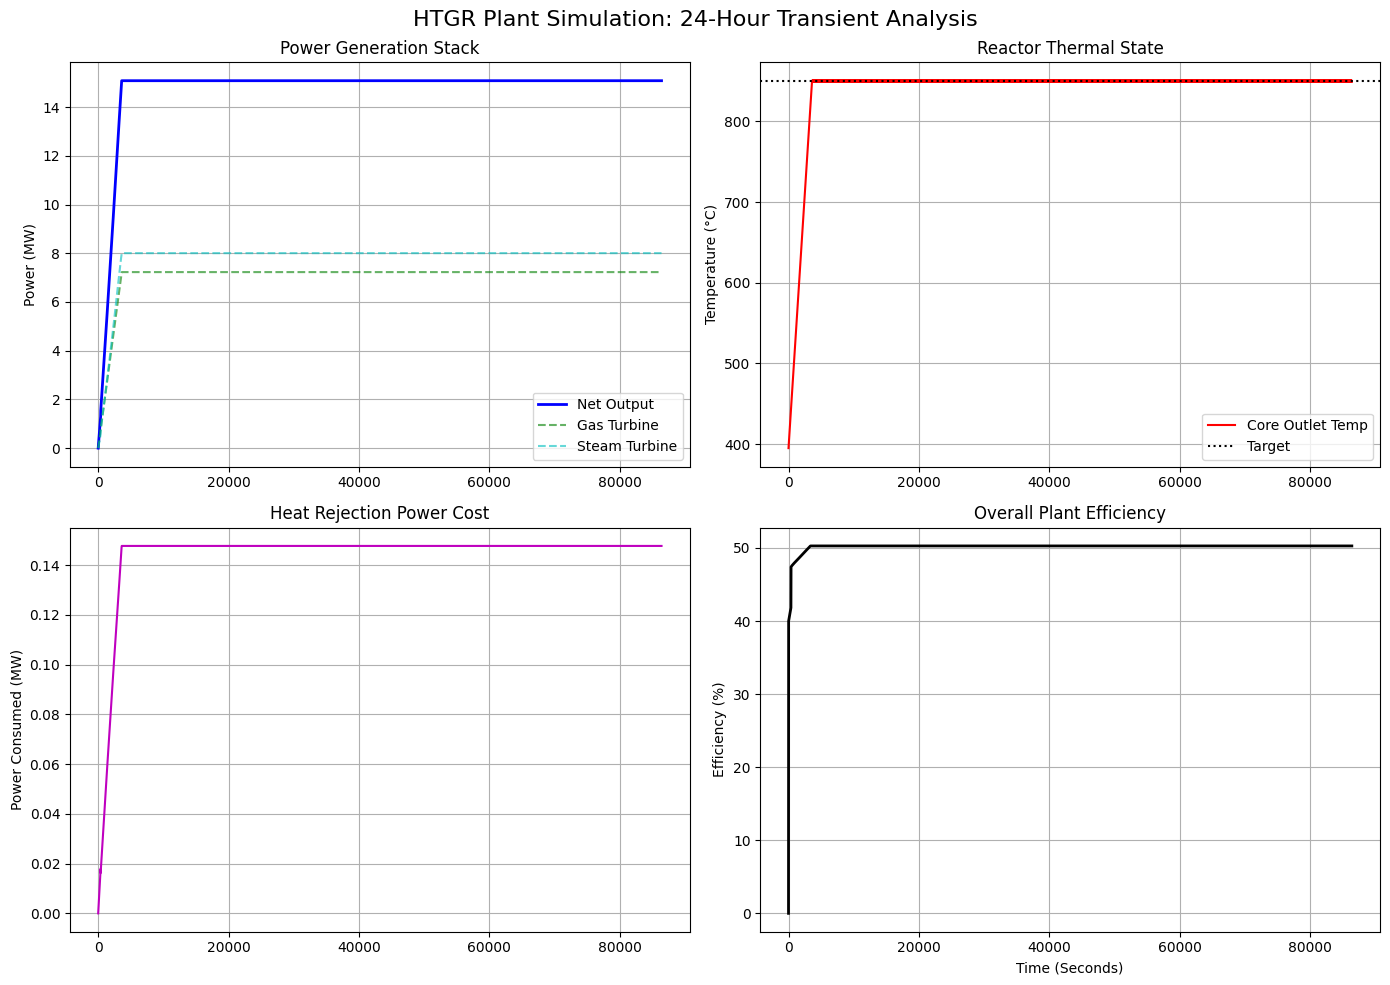

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Define paths
csv_path = os.path.join('..', 'results', 'simulation_log.csv')
lit_path = os.path.join('..', 'data', 'literature_data.csv')

if not os.path.exists(csv_path):
    print("ERROR: Run src/simulation.py first to generate data!")
else:
    df = pd.read_csv(csv_path)
    
    # 1. Conversions & Carbon Metrics
    df['Time_Hrs'] = df['Time'] / 3600.0
    co2_factor = 0.9  # Tonnes CO2 per MWh
    df['Energy_MWh'] = df['Net_Power_MW'] * (1.0 / 3600.0) 
    total_co2_saved = df['Energy_MWh'].sum() * co2_factor
    
    # 2. Load Literature Data (Validation Data)
    lit_df = None
    if os.path.exists(lit_path):
        lit_df = pd.read_csv(lit_path)
        print("Literature Data Loaded for Validation.")

    # 3. Setup the Dashboard
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('HTGR Plant Simulation: 24-Hour Transient Analysis & Validation', fontsize=16)

    # --- PLOT A: POWER GENERATION ---
    axs[0, 0].plot(df['Time_Hrs'], df['Net_Power_MW'], 'b-', linewidth=2, label='Net Output')
    axs[0, 0].plot(df['Time_Hrs'], df['Brayton_Power_MW'], 'g--', alpha=0.6, label='Gas Turbine')
    axs[0, 0].plot(df['Time_Hrs'], df['Rankine_Power_MW'], 'c--', alpha=0.6, label='Steam Turbine')
    axs[0, 0].set_title('Power Generation Stack')
    axs[0, 0].set_ylabel('Power (MW)')
    axs[0, 0].set_xlabel('Time (Hours)')
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # --- PLOT B: TEMPERATURES (WITH VALIDATION) ---
    axs[0, 1].plot(df['Time_Hrs'], df['Reactor_Temp_C'], 'r-', label='Simulated Core Temp')
    axs[0, 1].axhline(y=850, color='k', linestyle=':', label='Target (850°C)')
    
    # NEW: Plot the Literature Data points as Red Dots
    if lit_df is not None:
        # We assume the Literature Data represents steady-state points.
        # We plot them at the 12-hour mark for visual comparison.
        axs[0, 1].scatter([12]*len(lit_df), lit_df['outlet_temp_c'], 
                         color='red', zorder=5, label='HTTR Literature Data')
        
    axs[0, 1].set_title('Reactor Thermal State & Validation')
    axs[0, 1].set_ylabel('Temperature (°C)')
    axs[0, 1].set_xlabel('Time (Hours)')
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # --- PLOT C: PARASITIC LOAD & CO2 ---
    axs[1, 0].plot(df['Time_Hrs'], df['Parasitic_Load_MW'], 'm-')
    axs[1, 0].set_title('Heat Rejection Power Cost')
    axs[1, 0].set_ylabel('Power Consumed (MW)')
    axs[1, 0].set_xlabel('Time (Hours)')
    axs[1, 0].grid(True)
    axs[1, 0].text(0.5, 0.2, f'Total CO2 Saved:\n{total_co2_saved:.2f} Tonnes', 
                 transform=axs[1, 0].transAxes, fontsize=12, fontweight='bold',
                 ha='center', bbox=dict(facecolor='white', alpha=0.8))

    # --- PLOT D: EFFICIENCY ---
    axs[1, 1].plot(df['Time_Hrs'], df['System_Efficiency'] * 100, 'k-', linewidth=2)
    axs[1, 1].set_title('Overall Plant Efficiency')
    axs[1, 1].set_ylabel('Efficiency (%)')
    axs[1, 1].set_xlabel('Time (Hours)')
    axs[1, 1].grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()